# Treex

**Main features**:
* Modules contain their parameters
* Easy transfer learning
* Simple initialization
* No metaclass magic
* No apply method
* No need special versions of `vmap`, `jit`, and friends.

To prove the previous we will start with by creating a very contrived but complete module which will use everything from parameters, states, and random state:

In [1]:
from typing import Tuple
import jax.numpy as jnp
import numpy as np

import treex as tx


class NoisyStatefulLinear(tx.Module):
    # tree parts are defined by treex annotations
    w: tx.Parameter
    b: tx.Parameter
    count: tx.State
    rng: tx.Rng

    # other annotations are possible but ignored by type
    name: str

    def __init__(self, din, dout, name="noisy_stateful_linear"):
        self.name = name

        # Initializers only expect RNG key
        self.w = tx.Initializer(lambda k: jax.random.uniform(k, shape=(din, dout)))
        self.b = tx.Initializer(lambda k: jax.random.uniform(k, shape=(dout,)))

        # random state is JUST state, we can keep it locally
        self.rng = tx.Initializer(lambda k: k)

        # if value is known there is no need for an Initiaizer
        self.count = jnp.array(1)

    def __call__(self, x: np.ndarray) -> np.ndarray:
        assert isinstance(self.count, jnp.ndarray)
        assert isinstance(self.rng, jnp.ndarray)

        # state can easily be updated
        self.count = self.count + 1

        # random state is no different :)
        key, self.rng = jax.random.split(self.rng, 2)

        # your typical linear operation
        y = jnp.dot(x, self.w) + self.b

        # add noise for fun
        state_noise = 1.0 / self.count
        random_noise = 0.8 * jax.random.normal(key, shape=y.shape)

        return y + state_noise + random_noise

    def __repr__(self) -> str:
        return f"NoisyStatefulLinear(w={self.w}, b={self.b}, count={self.count}, rng={self.rng})"


linear = NoisyStatefulLinear(1, 1)

linear

NoisyStatefulLinear(w=Initializer, b=Initializer, count=1, rng=Initializer)

### Initialization
As advertised, initialization is easy, the only thing you need to do is to call `init` on your module with a random key:

In [2]:
import jax

linear = linear.init(key=jax.random.PRNGKey(42))
linear

NoisyStatefulLinear(w=[[0.91457367]], b=[0.42094743], count=1, rng=[1371681402 3011037117])

### Modules are Pytrees
Its fundamentally important that modules are also Pytrees, we can check that they are by using `tree_map` with an arbitrary function:

In [3]:
# its a pytree alright
doubled = jax.tree_map(lambda x: 2 * x, linear)
doubled

NoisyStatefulLinear(w=[[1.8291473]], b=[0.84189487], count=2, rng=[2743362804 1727106938])

### Modules can be sliced
An important feature of this Module system is that it can be sliced based on the type of its parameters, the `slice` method does exactly that:

In [4]:
params = linear.slice(tx.Parameter)
states = linear.slice(tx.State)

print(f"{params=}")
print(f"{states=}")

params=NoisyStatefulLinear(w=[[0.91457367]], b=[0.42094743], count=Nothing, rng=Nothing)
states=NoisyStatefulLinear(w=Nothing, b=Nothing, count=1, rng=[1371681402 3011037117])


Notice the following:
* Both `params` and `states` are `NoisyStatefulLinear` objects, their type doesn't change after being sliced.
* The fields that are filtered out by the `slice` on each field get a special value of type `tx.Nothing`.

Why is this important? As we will see later, it is useful keep parameters and state separate as they will crusially flow though different parts of `value_and_grad`.

### Modules can be merged
This is just the inverse operation to `slice`, `merge` behaves like dict's `update` but returns a new module leaving the original modules intact:

In [5]:
linear = params.merge(states)
linear

NoisyStatefulLinear(w=[[0.91457367]], b=[0.42094743], count=1, rng=[1371681402 3011037117])

### Modules compose
As you'd expect, you can have modules inside ther modules, same as previously the key is to annotate the class fields. Here we will create an `MLP` class that uses two `NoisyStatefulLinear` modules:

In [6]:
class MLP(tx.Module):
    linear1: NoisyStatefulLinear
    linear2: NoisyStatefulLinear

    def __init__(self, din, dmid, dout):
        self.linear1 = NoisyStatefulLinear(din, dmid, name="linear1")
        self.linear2 = NoisyStatefulLinear(dmid, dout, name="linear2")

    def __call__(self, x: np.ndarray) -> np.ndarray:
        x = jax.nn.relu(self.linear1(x))
        x = self.linear2(x)
        return x

    def __repr__(self) -> str:
        return f"MLP(linear1={self.linear1}, linear2={self.linear2})"


model = MLP(din=1, dmid=2, dout=1).init(key=42)
model

MLP(linear1=NoisyStatefulLinear(w=[[0.95598125 0.4032725 ]], b=[0.5371039  0.10409856], count=1, rng=[1371681402 3011037117]), linear2=NoisyStatefulLinear(w=[[0.7236692]
 [0.8625636]], b=[0.5354074], count=1, rng=[3818536016 1640990408]))

### Full Example
Using the previous `model` we will show how to train it using the proposed Module system. First lets get some data:

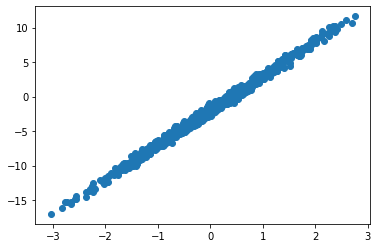

In [7]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)


def get_data(dataset_size: int) -> Tuple[np.ndarray, np.ndarray]:
    x = np.random.normal(size=(dataset_size, 1))
    y = 5 * x - 2 + 0.4 * np.random.normal(size=(dataset_size, 1))
    return x, y


def get_batch(
    data: Tuple[np.ndarray, np.ndarray], batch_size: int
) -> Tuple[np.ndarray, np.ndarray]:
    idx = np.random.choice(len(data[0]), batch_size)
    return jax.tree_map(lambda x: x[idx], data)


data = get_data(1000)

plt.scatter(data[0], data[1])
plt.show()

Now we will be reusing the previous MLP model, and we will create an optax optimizer that will be used to train the model:

In [8]:
import optax

optimizer = optax.adam(1e-2)

params = model.slice(tx.Parameter)
states = model.slice(tx.State)

opt_state = optimizer.init(params)

Notice that we are already splitting the model into `params` and `states` since we need to pass the `params` only to the optimizer. Next we will create the loss function, it will take the model parts and the data parts and return the loss plus the new states:

In [9]:
from functools import partial


@partial(jax.value_and_grad, has_aux=True)
def loss_fn(params: MLP, states: MLP, x, y):

    # merge params and states to get a full model
    model: MLP = params.merge(states)

    # apply model
    pred_y = model(x)

    # MSE loss
    loss = jnp.mean((y - pred_y) ** 2)

    # new states
    states = model.slice(tx.State)

    return loss, states

Notice that the first thing we are doing is merging the `params` and `states` into the complete model since we need everything in place to perform the forward pass. Also, we return the updated states from the model, this is needed because JAX functional API requires us to be explicit about state management.

**Note**: inside `loss_fn` (which is wrapped by `value_and_grad`) module can behave like a regular mutable python object, however, every time its treated as pytree a new reference will be created as happens in `jit`, `grad`, `vmap`, etc. Its important to keep this into account when using functions like `vmap` inside a module as certain book keeping will be needed to manage state correctly.

Next we will implement the `update` function, it will look indistinguishable from your standard Haiku update which also separates weights into `params` and `states`: 

In [10]:
@jax.jit
def update(params: MLP, states: MLP, opt_state, x, y):
    (loss, states), grads = loss_fn(params, states, x, y)
    updates, opt_state = optimizer.update(grads, opt_state, params)

    # use regular optax
    params = optax.apply_updates(params, updates)

    return params, states, opt_state, loss

Finally we create a simple training loop that perform a few thousand updates and merge `params` and `states` back into a single `model` at the end:

In [11]:
steps = 10_000

for step in range(steps):
    x, y = get_batch(data, batch_size=32)

    params, states, opt_state, loss = update(params, states, opt_state, x, y)

    if step % 1000 == 0:
        print(f"[{step}] loss = {loss}")

# get the final model
model = params.merge(states)

[0] loss = 36.88694763183594


[1000] loss = 2.011059045791626


[2000] loss = 5.2326812744140625


[3000] loss = 1.7426897287368774


[4000] loss = 1.2130391597747803


[5000] loss = 1.6681632995605469


[6000] loss = 1.029949426651001


[7000] loss = 1.301844835281372


[8000] loss = 0.878564715385437


[9000] loss = 1.4557385444641113


Now lets generate some test data and see how our model performed:

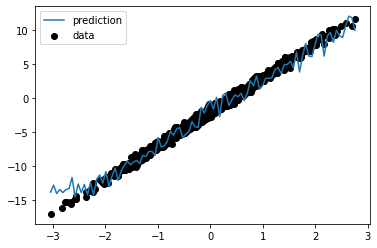

In [12]:
import matplotlib.pyplot as plt

X_test = np.linspace(data[0].min(), data[0].max(), 100)[:, None]
y_pred = model(X_test)

plt.scatter(data[0], data[1], label="data", color="k")
plt.plot(X_test, y_pred, label="prediction")
plt.legend()
plt.show()

As you can see the model learned the general trend but because of the `NoisyStatefulLinear` modules we have a bit of noise in the predictions.